First 5 rows of dataset:
        Date Region  Unemployment_Rate
0 2015-01-31  North           6.370861
1 2015-02-28  North          11.556429
2 2015-03-31  North           9.587945
3 2015-04-30  North           8.387926
4 2015-05-31  North           4.404168

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               432 non-null    datetime64[ns]
 1   Region             432 non-null    object        
 2   Unemployment_Rate  432 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 10.3+ KB
None

Summary Statistics:
                      Date  Unemployment_Rate
count                  432         432.000000
mean   2019-07-16 05:33:20           7.982262
min    2015-01-31 00:00:00           3.045554
25%    2017-04-22 12:00:00           5.490361
50%    2019-07-15 1

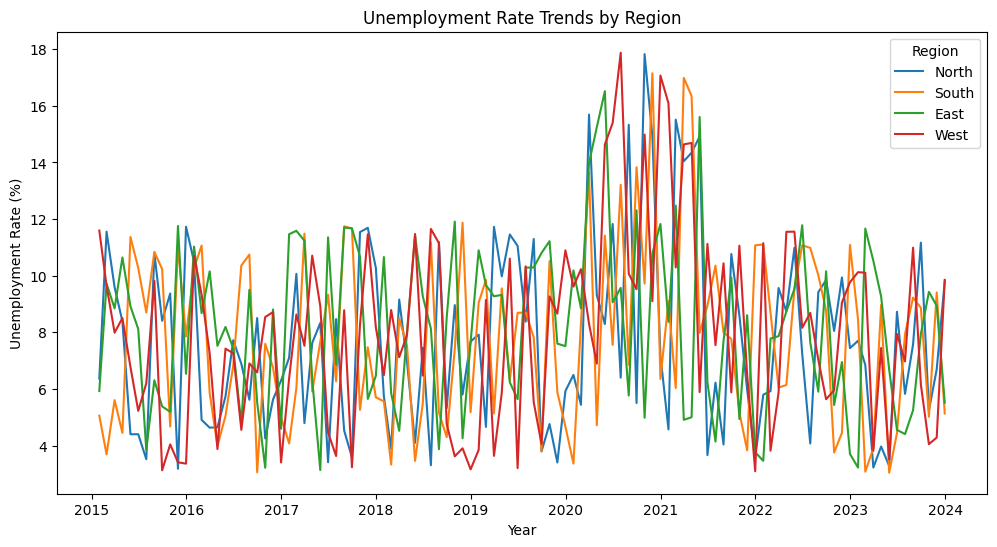

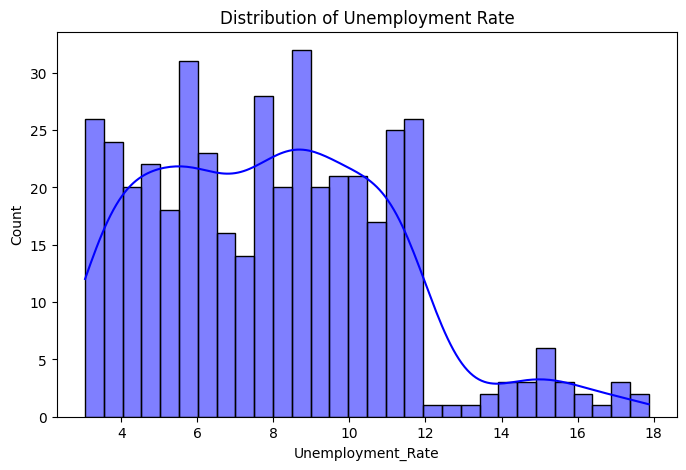

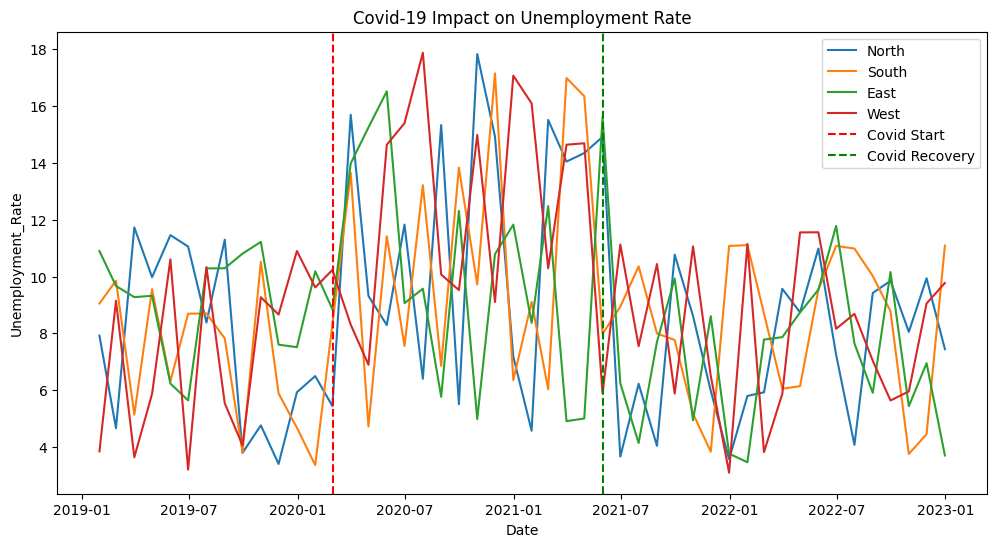


Training data shape: (345, 5)
Testing data shape: (87, 5)

Linear Regression Results:
MAE: 2.7280931810057276
RMSE: 3.2865161970640075
R² Score: 0.009422290678008594

Random Forest Results:
MAE: 2.8873533319651883
RMSE: 3.3949872425089485
R² Score: -0.0570445473966843

Model Comparison:
                        MAE      RMSE        R2
Linear Regression  2.728093  3.286516  0.009422
Random Forest      2.887353  3.394987 -0.057045


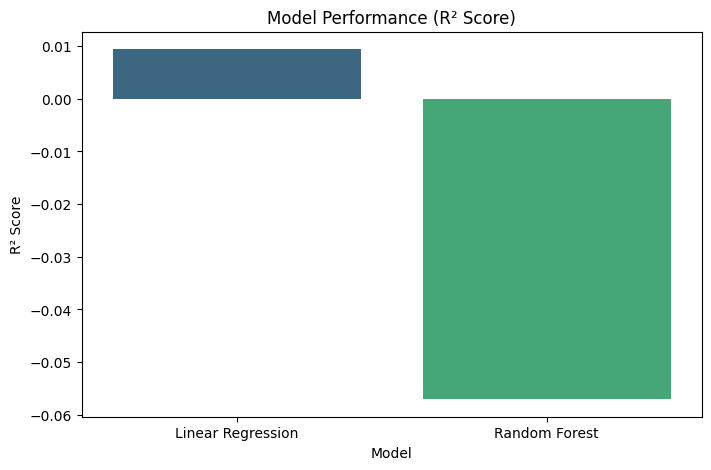

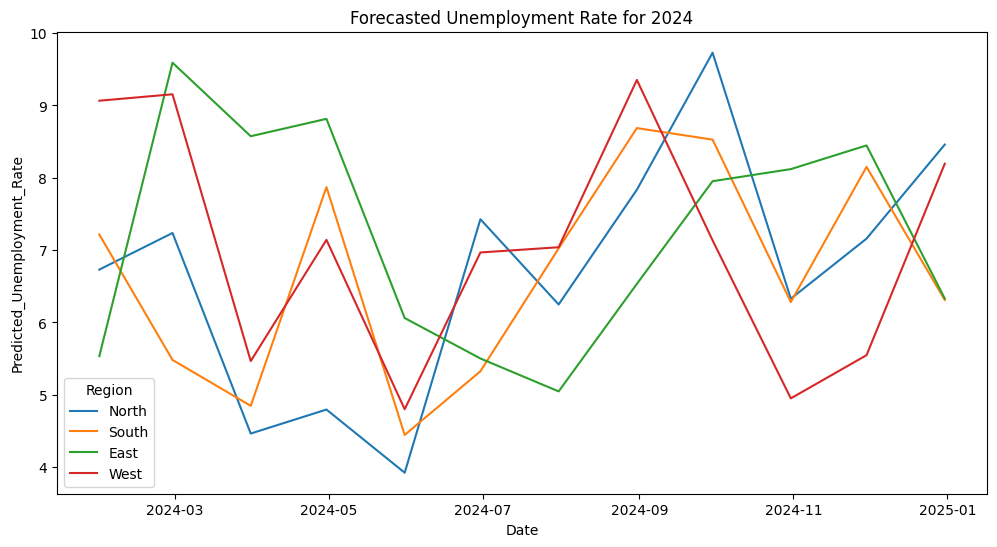


Forecasted Unemployment Sample:
        Date Region  Year  Month  Predicted_Unemployment_Rate
0 2024-01-31  North  2024      1                     6.730868
1 2024-02-29  North  2024      2                     7.237012
2 2024-03-31  North  2024      3                     4.464366
3 2024-04-30  North  2024      4                     4.796191
4 2024-05-31  North  2024      5                     3.922741


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
dates = pd.date_range(start="2015-01-01", end="2023-12-31", freq="M")
regions = ["North", "South", "East", "West"]

data = {
    "Date": np.tile(dates, len(regions)),
    "Region": np.repeat(regions, len(dates)),
    "Unemployment_Rate": np.random.uniform(3, 12, len(dates) * len(regions))
}

df = pd.DataFrame(data)

df.loc[df["Date"].between("2020-03-01", "2021-06-01"), "Unemployment_Rate"] *= 1.5

print("First 5 rows of dataset:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing values:")
print(df.isnull().sum())

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="Date", y="Unemployment_Rate", hue="Region")
plt.title("Unemployment Rate Trends by Region")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df["Unemployment_Rate"], bins=30, kde=True, color="blue")
plt.title("Distribution of Unemployment Rate")
plt.show()

plt.figure(figsize=(12,6))
covid_period = df[(df["Date"].between("2019-01-01", "2022-12-31"))]
sns.lineplot(data=covid_period, x="Date", y="Unemployment_Rate", hue="Region")
plt.axvline(pd.to_datetime("2020-03-01"), color="red", linestyle="--", label="Covid Start")
plt.axvline(pd.to_datetime("2021-06-01"), color="green", linestyle="--", label="Covid Recovery")
plt.legend()
plt.title("Covid-19 Impact on Unemployment Rate")
plt.show()

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

df_encoded = pd.get_dummies(df, columns=["Region"], drop_first=True)

X = df_encoded.drop(columns=["Date", "Unemployment_Rate"])
y = df_encoded["Unemployment_Rate"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"\n{name} Results:")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R² Score:", r2)

result_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(result_df)

plt.figure(figsize=(8,5))
sns.barplot(data=result_df.reset_index(), x="index", y="R2", palette="viridis")
plt.title("Model Performance (R² Score)")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.show()

best_model = RandomForestRegressor(n_estimators=200, random_state=42)
best_model.fit(X, y)

future_dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq="M")
future_data = pd.DataFrame({
    "Date": np.tile(future_dates, len(regions)),
    "Region": np.repeat(regions, len(future_dates)),
})

future_data["Year"] = future_data["Date"].dt.year
future_data["Month"] = future_data["Date"].dt.month
future_encoded = pd.get_dummies(future_data, columns=["Region"], drop_first=True)

future_pred = best_model.predict(future_encoded.drop(columns=["Date"]))

future_data["Predicted_Unemployment_Rate"] = future_pred

plt.figure(figsize=(12,6))
sns.lineplot(data=future_data, x="Date", y="Predicted_Unemployment_Rate", hue="Region")
plt.title("Forecasted Unemployment Rate for 2024")
plt.show()

print("\nForecasted Unemployment Sample:")
print(future_data.head())
